# Task 1

In [20]:
import numpy as np
import torch
from torch import nn
import tqdm
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [21]:

train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ]))

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

train_batch_size = 512
test_batch_size  = 256

train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

num_train_batches = len(train_batches)
num_val_batches = len(val_batches)
num_test_batches = len(test_batches)

#### Practicing good code documentation below

In [22]:
class ACAIGFCN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers):
        """
        Parameters:
          input_dim:  Dimension of input features
          output_dim: Dimension of output
          hidden_layers: List containing the number of neurons in each hidden layer.
        """
        super(ACAIGFCN, self).__init__()
        layers = []
        in_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, output_dim))
        self.network = nn.Sequential(*layers)
                
    def forward(self, x):
        return self.network(x)

hidden_layers = [128, 64]
learning_rate = 0.01
epochs = 10 # This one is changeable refer back to lectures if needed


In [23]:

# Initialize the model, loss function and optimizer
model = ACAIGFCN(input_dim=784, output_dim=10, hidden_layers=hidden_layers)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


train_loss_list = []
validation_accuracy_list = []

# Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
# Track the loss and validation accuracy
for epoch in tqdm.trange(epochs):
    model.train()
    running_loss = 0.0
    
    for train_features, train_labels in train_batches:
        train_features = train_features.reshape(-1, 28*28)
        optimizer.zero_grad()
        outputs = model(train_features)
        loss = loss_func(outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / num_train_batches
    train_loss_list.append(avg_loss)
    
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():
        for val_features, val_labels in val_batches:
            val_features = val_features.reshape(-1, 28*28)
            outputs = model(val_features)
            # Get the predicted class with highest probability
            _, predicted = torch.max(outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    val_accuracy = correct / total
    validation_accuracy_list.append(val_accuracy)
    
    print(f"Epoch {epoch+1}: Training Loss = {avg_loss:.4f}, Validation Accuracy = {val_accuracy*100:.2f}%")

 10%|█         | 1/10 [00:07<01:08,  7.66s/it]

Epoch 1: Training Loss = 1.9894, Validation Accuracy = 62.75%


 20%|██        | 2/10 [00:14<00:56,  7.02s/it]

Epoch 2: Training Loss = 1.1920, Validation Accuracy = 68.28%


 30%|███       | 3/10 [00:20<00:46,  6.59s/it]

Epoch 3: Training Loss = 0.8856, Validation Accuracy = 71.85%


 40%|████      | 4/10 [00:26<00:38,  6.42s/it]

Epoch 4: Training Loss = 0.7694, Validation Accuracy = 74.20%


 50%|█████     | 5/10 [00:33<00:32,  6.55s/it]

Epoch 5: Training Loss = 0.6995, Validation Accuracy = 75.77%


 60%|██████    | 6/10 [00:42<00:29,  7.48s/it]

Epoch 6: Training Loss = 0.6500, Validation Accuracy = 77.47%


 70%|███████   | 7/10 [00:54<00:26,  8.87s/it]

Epoch 7: Training Loss = 0.6135, Validation Accuracy = 78.67%


 80%|████████  | 8/10 [00:59<00:15,  7.86s/it]

Epoch 8: Training Loss = 0.5843, Validation Accuracy = 79.28%


 90%|█████████ | 9/10 [01:05<00:07,  7.20s/it]

Epoch 9: Training Loss = 0.5613, Validation Accuracy = 80.25%


100%|██████████| 10/10 [01:11<00:00,  7.13s/it]

Epoch 10: Training Loss = 0.5430, Validation Accuracy = 80.80%


### Below code has been referenced from when I took CSE 579 Reinforcement Learning!!

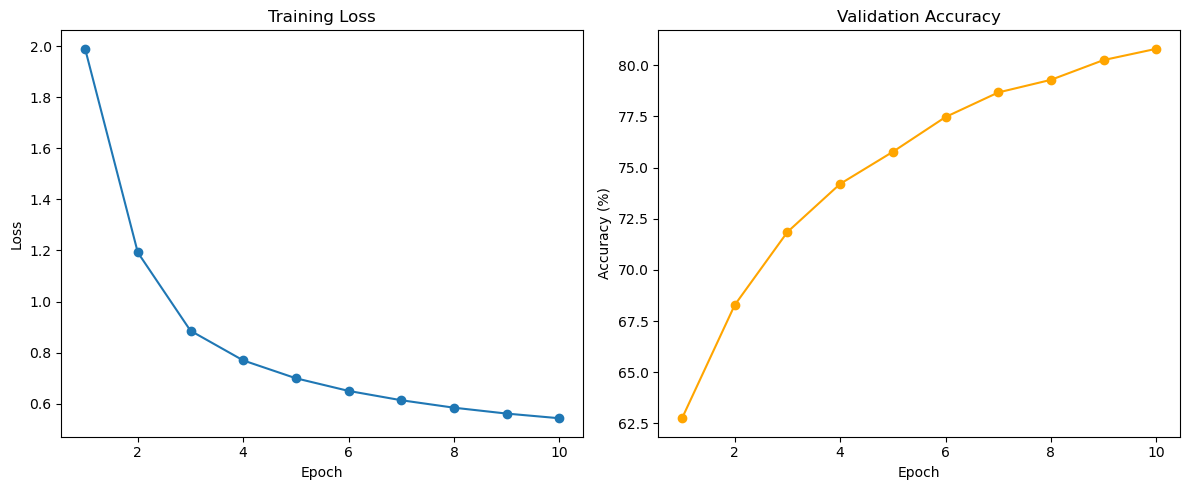

In [24]:

# Plot training loss (this code has been referenced from when I took CSE 579)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_loss_list, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), [acc*100 for acc in validation_accuracy_list], marker='o', color='orange')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.show()

In [25]:

# Testing phase: compute the test accuracy
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
    for test_features, test_labels in test_batches:
        test_features = test_features.reshape(-1, 28*28)
        outputs = model(test_features)
        _, predicted = torch.max(outputs, 1)
        total_test += test_labels.size(0)
        correct_test += (predicted == test_labels).sum().item()

test_accuracy = correct_test / total_test
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Test Accuracy: 80.00%
